In [1]:
import numpy as np
import ltfatpy

def substractMeanAndDivideByStd(aDistribution):
    unmeaned = aDistribution - np.mean(aDistribution, axis=(1, 2), keepdims=True)     
    shiftedtt = unmeaned/np.sqrt(np.sum(np.square(np.abs(unmeaned)), axis=(1, 2), keepdims=True))
    return shiftedtt

def consistency(spectrogram, ttconstant, ffconstant):
    ttderiv = spectrogram[:, 1:-1, :-2] - 2*spectrogram[:, 1:-1, 1:-1] + spectrogram[:, 1:-1, 2:] + ttconstant #np.pi / 4
    ffderiv = spectrogram[:, :-2, 1:-1] - 2*spectrogram[:, 1:-1, 1:-1] + spectrogram[:, 2:, 1:-1] + ffconstant #np.pi / 4 
       
    absttderiv = substractMeanAndDivideByStd(np.abs(ttderiv))
    absffderiv = substractMeanAndDivideByStd(np.abs(ffderiv))

    consistencies = np.sum(absttderiv*absffderiv, axis=(1,2))
    return consistencies

In [2]:
import librosa
import numpy as np
import os

pathToDatasetFolder = 'commands'
audios = []
i = 0
total = 0
print('start')
for file_name in os.listdir(pathToDatasetFolder):
    if file_name.endswith('.wav'):      
        audio, sr = librosa.load(pathToDatasetFolder + '/' + file_name, sr=None, dtype=np.float64)

        if len(audio) < 16000:
            before = int(np.floor((16000-len(audio))/2))
            after = int(np.ceil((16000-len(audio))/2))
            audio = np.pad(audio, (before, after), 'constant', constant_values=(0, 0))
#             if len(audio) < 16000:
#                 print(file_name, "is too short: ", len(audio))
#                 continue
        if len(audio) > 16000: 
            print(file_name, "is too long: ", len(audio))
        if np.sum(np.absolute(audio)) < len(audio)*1e-4: 
            print(file_name, "doesn't meet the minimum amplitude requirement")
            continue

        audios.append(audio[:16000])
        i+=1

        if i > 1000:
            i -= 1000
            total += 1000
            print("1000 plus!", total)
print("there were: ", total+i)

# audios = audios.finalize()
audios = np.reshape(audios, (total+i, len(audio))).astype(np.float64)

start
there were:  64


In [3]:
audio, sr = librosa.load('piano/00.wav', sr=None, dtype=np.float64)
audio = audio[:16000*64]
pianos = np.reshape(audio, (64, 16000)).astype(np.float64)

In [4]:
import ltfatpy
class LTFATStft(object):
    def oneSidedStft(self, signal, windowLength, hopSize):
        gs = {'name': 'gauss', 'M': windowLength}
        return ltfatpy.dgtreal(signal, gs, hopSize, windowLength)[0]

    def inverseOneSidedStft(self, signal, windowLength, hopSize):
        synthesis_window = {'name': 'gauss', 'M': windowLength}
        analysis_window = {'name': ('dual', synthesis_window['name']), 'M': synthesis_window['M']}

        return ltfatpy.idgtreal(signal, analysis_window, hopSize, windowLength)[0]

    def magAndPhaseOneSidedStft(self, signal, windowLength, hopSize):
        stft = self.oneSidedStft(signal, windowLength, hopSize)
        return np.abs(stft), np.angle(stft)

    def log10MagAndPhaseOneSidedStft(self, signal, windowLength, hopSize, clipBelow=1e-14):
        realDGT = self.oneSidedStft(signal, windowLength, hopSize)
        return self.log10MagFromRealDGT(realDGT, clipBelow), np.angle(realDGT)

    def log10MagFromRealDGT(self, realDGT, clipBelow=1e-14):
        return np.log10(np.clip(np.abs(realDGT), a_min=clipBelow, a_max=None))

    def reconstructSignalFromLogged10Spectogram(self, logSpectrogram, phase, windowLength, hopSize):
        reComplexStft = (10 ** logSpectrogram) * np.exp(1.0j * phase)
        return self.inverseOneSidedStft(reComplexStft, windowLength, hopSize)

    def logMagAndPhaseOneSidedStft(self, signal, windowLength, hopSize, clipBelow=np.e**-30, normalize=False):
        realDGT = self.oneSidedStft(signal, windowLength, hopSize)
        spectrogram = self.logMagFromRealDGT(realDGT, clipBelow, normalize)
        return spectrogram, np.angle(realDGT)

    def logMagFromRealDGT(self, realDGT, clipBelow=np.e**-30, normalize=False):
        spectrogram = np.abs(realDGT)
        if normalize:
            spectrogram = spectrogram/np.max(spectrogram)
        return np.log(np.clip(spectrogram, a_min=clipBelow, a_max=None))

    def reconstructSignalFromLoggedSpectogram(self, logSpectrogram, phase, windowLength, hopSize):
        reComplexStft = (np.e ** logSpectrogram) * np.exp(1.0j * phase)
        return self.inverseOneSidedStft(reComplexStft, windowLength, hopSize)


In [5]:
# from ourLTFATStft import LTFATStft

fft_hop_size = 128
fft_window_length = 512
Ltrue = 16384

anStftWrapper = LTFATStft()
spectrograms = np.zeros([len(audios), fft_window_length//2+1, Ltrue//fft_hop_size], dtype=np.float64)
print(spectrograms.shape)
    
for index, audio in enumerate(audios):
    realDGT = anStftWrapper.oneSidedStft(signal=audio, windowLength=fft_window_length, hopSize=fft_hop_size)
    spectrogram = anStftWrapper.logMagFromRealDGT(realDGT, clipBelow=np.e**-10, normalize=True)
    spectrograms[index] = spectrogram

(64, 257, 128)


In [6]:
gs = {'name': 'gauss'}
[g,info] = ltfatpy.gabwin(gs,fft_hop_size,fft_window_length,Ltrue);
tfr = info['tfr']
b = Ltrue/fft_window_length

ttconstant = np.pi*fft_hop_size**2/tfr/Ltrue
ffconstant = np.pi*b**2*tfr/Ltrue

realconsistencies = consistency(spectrograms, ttconstant, ffconstant)

print(np.mean(realconsistencies))

print('--------')

0.7083105028979355
--------


In [7]:
tfr_hann = 4.1157

In [8]:
def computeConsistencyFor(signals, hopSize, windowLength):
    Ltrue = 16384

    anStftWrapper = LTFATStft()
    spectrograms = np.zeros([len(signals), windowLength//2+1, Ltrue//hopSize], dtype=np.float64)
    print(spectrograms.shape)

    for index, audio in enumerate(signals):
        realDGT = anStftWrapper.oneSidedStft(signal=audio, windowLength=windowLength, hopSize=hopSize)
        spectrogram = anStftWrapper.logMagFromRealDGT(realDGT, clipBelow=np.e**-16, normalize=True)
        spectrograms[index] = spectrogram
    
    gs = {'name': 'gauss'}
    [g,info] = ltfatpy.gabwin(gs,hopSize,windowLength,Ltrue);
    tfr = info['tfr']
    b = Ltrue/windowLength

    ttconstant = np.pi*hopSize**2/tfr/Ltrue
    ffconstant = np.pi*b**2*tfr/Ltrue

    return consistency(spectrograms, ttconstant, ffconstant)
    

In [9]:
def computeHannConsistencyFor(signals, hopSize, windowLength):
    Ltrue = 16384

    anStftWrapper = LTFATStft()
    spectrograms = np.zeros([len(signals), windowLength//2+1, Ltrue//hopSize], dtype=np.float64)

    for index, audio in enumerate(signals):
        gs = {'name': 'hann', 'M': windowLength}
        realDGT = ltfatpy.dgtreal(audio, gs, hopSize, windowLength)[0]
        spectrogram = anStftWrapper.logMagFromRealDGT(realDGT, clipBelow=np.e**-16, normalize=True)
        spectrograms[index] = spectrogram
    
    tfr_hann = 4.1157
    b = Ltrue/windowLength

    ttconstant = np.pi*hopSize**2/tfr_hann/Ltrue
    ffconstant = np.pi*b**2*tfr_hann/Ltrue

    return consistency(spectrograms, ttconstant, ffconstant)

In [10]:
def computeNoiseConsistencyFor(signals, hopSize, windowLength):
    Ltrue = 16384

    anStftWrapper = LTFATStft()
    spectrograms = np.zeros([len(signals), windowLength//2+1, Ltrue//hopSize], dtype=np.float64)
    noise = (np.random.normal(size=(windowLength//2+1, Ltrue//hopSize))+1.0j* np.random.normal(size=(windowLength//2+1, Ltrue//hopSize)))


    for index, audio in enumerate(signals):
#         realDGT = anStftWrapper.oneSidedStft(signal=audio, windowLength=windowLength, hopSize=hopSize)
        spectrogram = anStftWrapper.logMagFromRealDGT(noise, clipBelow=np.e**-16, normalize=True)
        spectrograms[index] = spectrogram
    
    gs = {'name': 'gauss'}
    [g,info] = ltfatpy.gabwin(gs,hopSize,windowLength,Ltrue);
    tfr = info['tfr']
    b = Ltrue/windowLength

    ttconstant = np.pi*hopSize**2/tfr/Ltrue
    ffconstant = np.pi*b**2*tfr/Ltrue

    return consistency(spectrograms, ttconstant, ffconstant)
    

In [11]:
print(np.mean(computeConsistencyFor(audios, 512, 512)))

(64, 257, 32)
0.5763631611850872


In [12]:
consistencies = []
channels = 512
redundancies = [1/2, 1, 2, 4, 8, 16, channels/16, channels/8, channels/4, channels]

for redundancy in redundancies:
    consistencies.append(computeConsistencyFor(audios, int(channels/redundancy), channels))
    
consistencies = np.reshape(consistencies, (len(redundancies), len(audios)))

(64, 257, 16)
(64, 257, 32)
(64, 257, 64)
(64, 257, 128)
(64, 257, 256)
(64, 257, 512)
(64, 257, 1024)
(64, 257, 2048)
(64, 257, 4096)
(64, 257, 16384)


In [13]:
piano_consistencies = []

for redundancy in redundancies:
    piano_consistencies.append(computeConsistencyFor(pianos, int(channels/redundancy), channels))
    
piano_consistencies = np.reshape(piano_consistencies, (len(redundancies), len(pianos)))

(64, 257, 16)
(64, 257, 32)
(64, 257, 64)
(64, 257, 128)
(64, 257, 256)
(64, 257, 512)
(64, 257, 1024)
(64, 257, 2048)
(64, 257, 4096)
(64, 257, 16384)


In [15]:
commands_hann_consistencies = []
channels = 512
redundancies = [1/2, 1, 2, 4, 8, 16, channels/16, channels/8, channels/4, channels]

for redundancy in redundancies:
    print(redundancy)
    commands_hann_consistencies.append(computeHannConsistencyFor(audios, int(channels/redundancy), channels))
    
commands_hann_consistencies = np.reshape(commands_hann_consistencies, (len(redundancies), len(audios)))


0.5
1
2
4
8
16
32.0
64.0
128.0
512


In [16]:
piano_hann_consistencies = []
channels = 512
redundancies = [1/2, 1, 2, 4, 8, 16, channels/16, channels/8, channels/4, channels]

for redundancy in redundancies:
    print(redundancy)
    piano_hann_consistencies.append(computeHannConsistencyFor(pianos, int(channels/redundancy), channels))
    
piano_hann_consistencies = np.reshape(piano_hann_consistencies, (len(redundancies), len(audios)))


0.5
1
2
4
8
16
32.0
64.0
128.0
512


In [14]:
noise_consistencies = []
channels = 512
redundancies = [1/2, 1, 2, 4, 8, 16, channels/16, channels/8, channels/4, channels]

for redundancy in redundancies:
    print(redundancy)
    noise_consistencies.append(computeNoiseConsistencyFor(pianos, int(channels/redundancy), channels))
    
noise_consistencies = np.reshape(noise_consistencies, (len(redundancies), len(audios)))

0.5
1
2
4
8
16
32.0
64.0
128.0
512


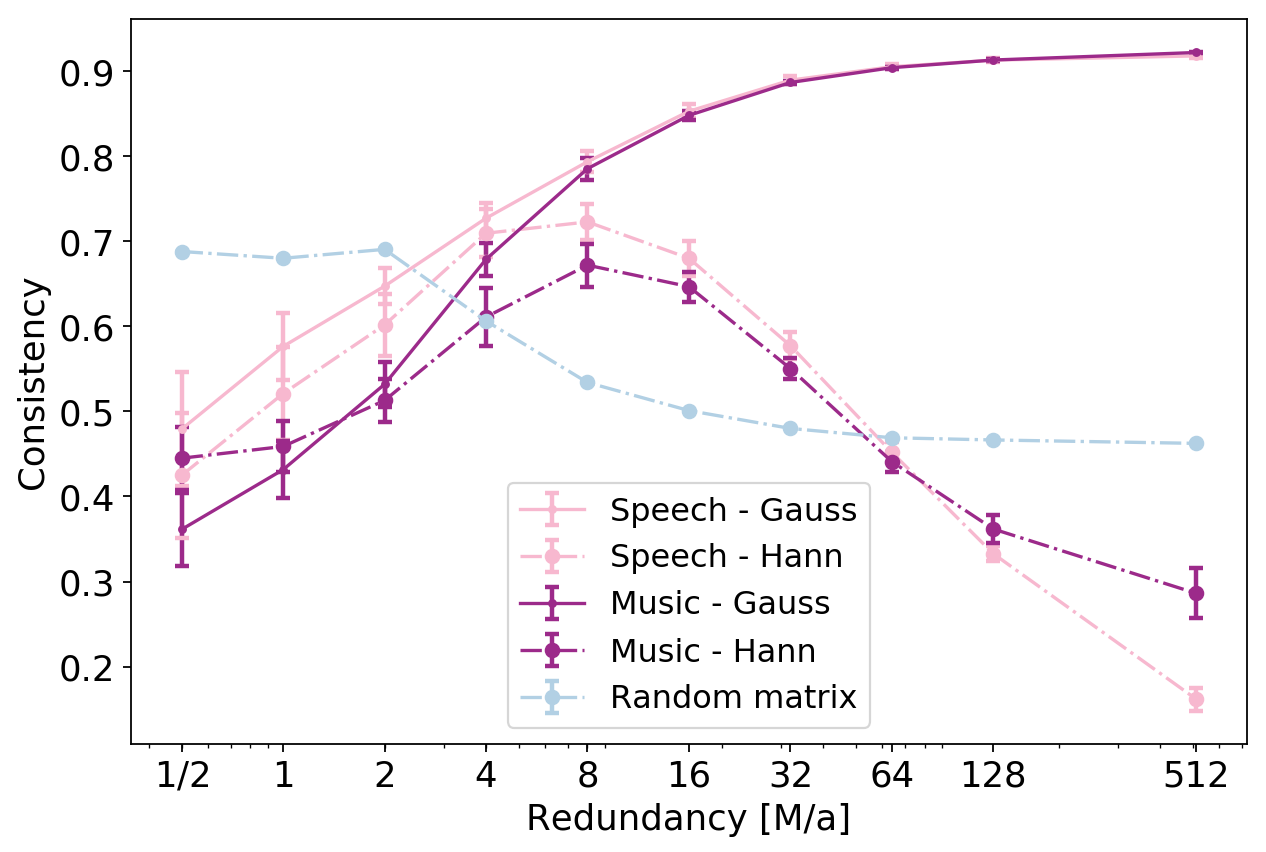

In [17]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

plt.figure(num=None, figsize=(9, 6), dpi=160, facecolor='w', edgecolor='k')
plt.ylabel('Consistency', fontsize=16)
plt.xlabel('Redundancy [M/a]', fontsize=16)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.set_xscale("log", nonposx='clip')

plt.errorbar(redundancies, np.mean(consistencies, 1), np.std(consistencies, 1), color='#f7b8cf', label='Speech - Gauss', fmt='.-', capthick=2,elinewidth=2,capsize=3,zorder=10)
plt.errorbar(redundancies, np.mean(commands_hann_consistencies, 1), np.std(commands_hann_consistencies, 1), label='Speech - Hann', color='#f7b8cf', fmt='o-.',capthick=2,elinewidth=2,capsize=3,zorder=10)
plt.errorbar(redundancies, np.mean(piano_consistencies, 1), np.std(piano_consistencies, 1), label='Music - Gauss', fmt='.-', color='#9c2a8a',capthick=2,elinewidth=2,capsize=3,zorder=10)
plt.errorbar(redundancies, np.mean(piano_hann_consistencies, 1), np.std(piano_hann_consistencies, 1), label='Music - Hann', fmt='o-.', color='#9c2a8a',capthick=2,elinewidth=2,capsize=3,zorder=10)
plt.errorbar(redundancies, np.mean(noise_consistencies, 1), np.std(noise_consistencies, 1), label='Random matrix', fmt='o-.', color='#b2d0e4',capthick=2,elinewidth=2,capsize=3,zorder=10)

plt.legend(fontsize='x-large')


# redundancies = [1e2, 5e2, 1e3, 2e3, 4e3, 8e3]
ticks_labels = [str(int(x)) for x in redundancies]
ticks_labels[0] = r'$1/2$'
plt.xticks(redundancies, ticks_labels);

plt.savefig('consistency_per_redundancy.pdf',bbox_inches='tight', pad_inches=0.1)

In [18]:
def computeNoisyConsistencyFor(signals, snrdB, hopSize, windowLength):
    Ltrue = 16384

    anStftWrapper = LTFATStft()
    spectrograms = np.zeros([len(signals), windowLength//2+1, Ltrue//hopSize], dtype=np.float64)
    noise = np.random.normal(size=(windowLength//2+1, Ltrue//hopSize))+1.0j* np.random.normal(size=(windowLength//2+1, Ltrue//hopSize))

    noise_level = 10**(-snrdB/10)
             
#     print(spectrograms.shape)
#     noise = noiseLevel * (np.random.normal(size=(windowLength//2+1, Ltrue//hopSize))+1.0j* np.random.normal(size=(windowLength//2+1, Ltrue//hopSize)))

    for index, audio in enumerate(signals):
        realDGT = anStftWrapper.oneSidedStft(signal=audio, windowLength=windowLength, hopSize=hopSize)
        dgt_noised = realDGT/np.linalg.norm(realDGT, 'fro') + noise_level * noise/ np.linalg.norm(noise, 'fro')
             
        spectrogram = anStftWrapper.logMagFromRealDGT(dgt_noised, clipBelow=np.e**-16, normalize=True)
        spectrograms[index] = spectrogram 
    
    gs = {'name': 'gauss'}
    [g,info] = ltfatpy.gabwin(gs,hopSize,windowLength,Ltrue);
    tfr = info['tfr']
    b = Ltrue/windowLength

    ttconstant = np.pi*hopSize**2/tfr/Ltrue
    ffconstant = np.pi*b**2*tfr/Ltrue

    return consistency(spectrograms, ttconstant, ffconstant)

In [19]:
normalized_audios = []

for audio in audios:
    normalized_audios.append(audio/np.max([np.abs(np.min(audio)), np.max(audio)], 0))

normalized_audios = np.reshape(normalized_audios, (len(audios), len(audios[0])))

In [20]:
commands_noisy_consistencies = []
noise_levels = [0, 10, 20, 30, 40, 50, 60, 70, 80]
channels = 512
redundancy = 8

for noise_level in noise_levels:
    commands_noisy_consistencies.append(computeNoisyConsistencyFor(normalized_audios, noise_level, int(channels/redundancy), channels))
    
commands_noisy_consistencies = np.reshape(commands_noisy_consistencies, (len(noise_levels), len(normalized_audios)))

In [21]:
commands_noisy_consistencies_red4 = []
noise_levels = [0, 10, 20, 30, 40, 50, 60, 70, 80]
channels = 512
redundancy = 4

for noise_level in noise_levels:
    commands_noisy_consistencies_red4.append(computeNoisyConsistencyFor(normalized_audios, noise_level, int(channels/redundancy), channels))
    
commands_noisy_consistencies_red4 = np.reshape(commands_noisy_consistencies_red4, (len(noise_levels), len(normalized_audios)))

In [22]:
normalized_pianos = []

for audio in pianos:
    normalized_pianos.append(audio/np.max([np.abs(np.min(audio)), np.max(audio)], 0))

normalized_pianos = np.reshape(normalized_pianos, (len(pianos), len(pianos[0])))

In [23]:
piano_noisy_consistencies = []
noise_levels = [0, 10, 20, 30, 40, 50, 60, 70, 80]
channels = 512
redundancy = 8

for noise_level in noise_levels:
    piano_noisy_consistencies.append(computeNoisyConsistencyFor(normalized_pianos, noise_level, int(channels/redundancy), channels))
    
piano_noisy_consistencies = np.reshape(piano_noisy_consistencies, (len(noise_levels), len(normalized_pianos)))

In [24]:
piano_noisy_consistencies_red4 = []
noise_levels = [0, 10, 20, 30, 40, 50, 60, 70, 80]
channels = 512
redundancy = 4

for noise_level in noise_levels:
    piano_noisy_consistencies_red4.append(computeNoisyConsistencyFor(normalized_pianos, noise_level, int(channels/redundancy), channels))
    
piano_noisy_consistencies_red4 = np.reshape(piano_noisy_consistencies_red4, (len(noise_levels), len(normalized_pianos)))

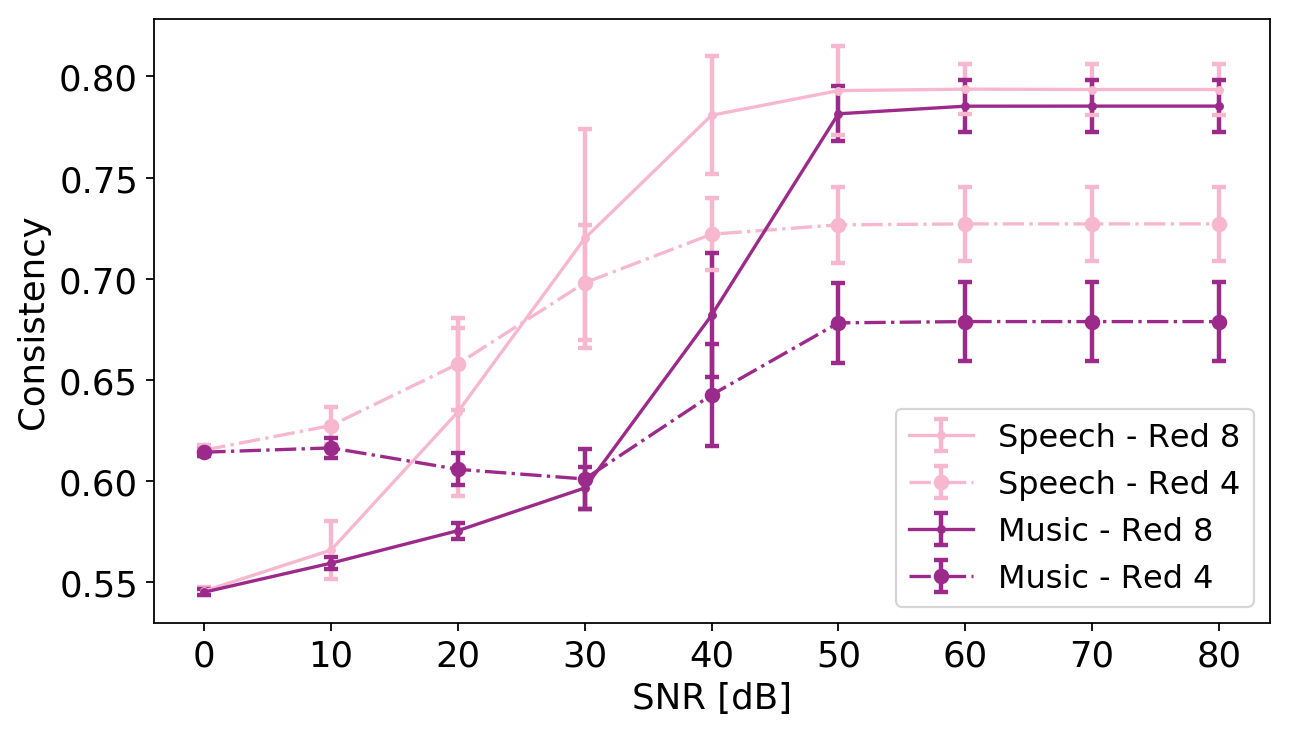

In [25]:
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(9, 5), dpi=160, facecolor='w', edgecolor='k')
plt.ylabel('Consistency', fontsize=16)
plt.xlabel('SNR [dB]', fontsize=16)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
# ax.set_xscale("log", nonposx='clip')

plt.errorbar(noise_levels, np.mean(commands_noisy_consistencies, 1), np.std(commands_noisy_consistencies, 1), color='#f7b8cf', label='Speech - Red 8', fmt='.-', capthick=2,elinewidth=2,capsize=3,zorder=10)
plt.errorbar(noise_levels, np.mean(commands_noisy_consistencies_red4, 1), np.std(commands_noisy_consistencies_red4, 1), label='Speech - Red 4', color='#f7b8cf', fmt='o-.',capthick=2,elinewidth=2,capsize=3,zorder=10)
plt.errorbar(noise_levels, np.mean(piano_noisy_consistencies, 1), np.std(piano_noisy_consistencies, 1), label='Music - Red 8', fmt='.-', color='#9c2a8a',capthick=2,elinewidth=2,capsize=3,zorder=10)
plt.errorbar(noise_levels, np.mean(piano_noisy_consistencies_red4, 1), np.std(piano_noisy_consistencies_red4, 1), label='Music - Red 4', fmt='o-.', color='#9c2a8a',capthick=2,elinewidth=2,capsize=3,zorder=10)
# plt.errorbar(noise_levels, np.mean(noisy_only, 1), np.std(noisy_only, 1), label='Random - Red 8', fmt='.-', color='#b2d0e4',capthick=2,elinewidth=2,capsize=3,zorder=10)
# plt.errorbar(noise_levels, np.mean(noisy_only_red4, 1), np.std(noisy_only_red4, 1), label='Random - Red 4', fmt='o-.', color='#b2d0e4',capthick=2,elinewidth=2,capsize=3,zorder=10)


plt.legend(fontsize='x-large')


# redundancies = [1e2, 5e2, 1e3, 2e3, 4e3, 8e3]
# noise_levels[0] = 0
ticks_labels = [str(x) for x in noise_levels]
# ticks_labels[0] = r'$1/2$'
# noise_levels[0] = 0
plt.xticks(noise_levels, ticks_labels);

plt.savefig('consistency_noisy_no_floor.pdf',bbox_inches='tight', pad_inches=0.1)